In [1]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 

### Data & Split

In [2]:
start_date = "2020-1-1"
end_date = "2025-9-1"
ticker = "^GSPC"

df = yf.download(ticker, start_date, end_date)
df.columns = df.columns.get_level_values(0)
df.columns.name = None

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
def compute_rsi(df, column, period):
    delta = df[column].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(com=period-1, adjust=False).mean()
    avg_loss = loss.ewm(com=period-1, adjust=False).mean()

    rs = avg_gain / avg_loss
    df[f"RSI_{period}"] = 100 - (100 / (1+rs))
    
    return df

df = compute_rsi(df, "Close", 14)

In [4]:
df["Log_returns"] = np.log(df["Close"]/df["Close"].shift(1))
df["Historical_vol"] = df["Log_returns"].rolling(window=20).std()*np.sqrt(252)

df["Lag_1"] = df["Log_returns"].shift(1)
df["Lag_2"] = df["Log_returns"].shift(2)
df["Lag_5"] = df["Log_returns"].shift(5) 

df["Log_volume"] = np.log(df["Volume"])


C:\Users\sonny\anaconda3\envs\project_finance\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df.columns.to_list()

['Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'RSI_14',
 'Log_returns',
 'Historical_vol',
 'Lag_1',
 'Lag_2',
 'Lag_5',
 'Log_volume']

In [6]:
df = df.drop(["High", "Close", "Open", "Low", "Volume"], axis=1)
df

,RSI_14,Log_returns,Historical_vol,Lag_1,Lag_2,Lag_5,Log_volume
Date,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,21.964514
2020-01-03,0.000000,-0.007085,NaN,NaN,NaN,NaN,21.971648
2020-01-06,3.681968,0.003527,NaN,-0.007085,NaN,NaN,22.032263
2020-01-07,3.569288,-0.002807,NaN,0.003527,-0.007085,NaN,21.957548
2020-01-08,8.810506,0.004890,NaN,-0.002807,0.003527,NaN,22.038827
...,...,...,...,...,...,...,...
2025-08-25,58.943260,-0.004276,0.120061,0.015072,-0.004012,-0.000101,22.124220
2025-08-26,61.395130,0.004125,0.120075,-0.004276,0.015072,-0.005875,22.305883
2025-08-27,62.785123,0.002388,0.119969,0.004125,-0.004276,-0.002435,22.144850


RSI_14             1
Log_returns        1
Historical_vol    20
Lag_1              2
Lag_2              3
Lag_5              6
Log_volume         1
dtype: int64


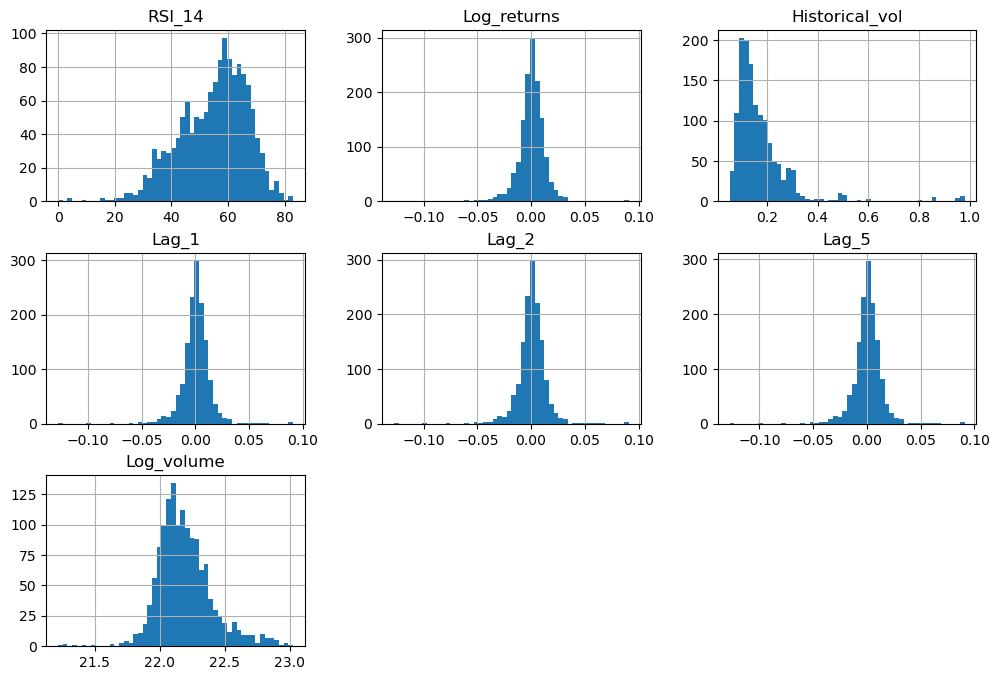

In [7]:
df = df.replace([np.inf, -np.inf], np.nan)
print(df.isna().sum())
df.hist(bins=50, figsize=(12,8))
plt.show()

In [8]:
df = df.dropna(subset=["Log_returns"])

split = int(len(df)*0.8)
train_set = df.iloc[:split]
test_set = df.iloc[split:]

print(f"Train set {train_set.index.min()} -> {train_set.index.max()}")
print(f"Test set {test_set.index.min()} -> {test_set.index.max()}")

Train set 2020-01-03 00:00:00 -> 2024-07-11 00:00:00
Test set 2024-07-12 00:00:00 -> 2025-08-29 00:00:00


### Exploration 

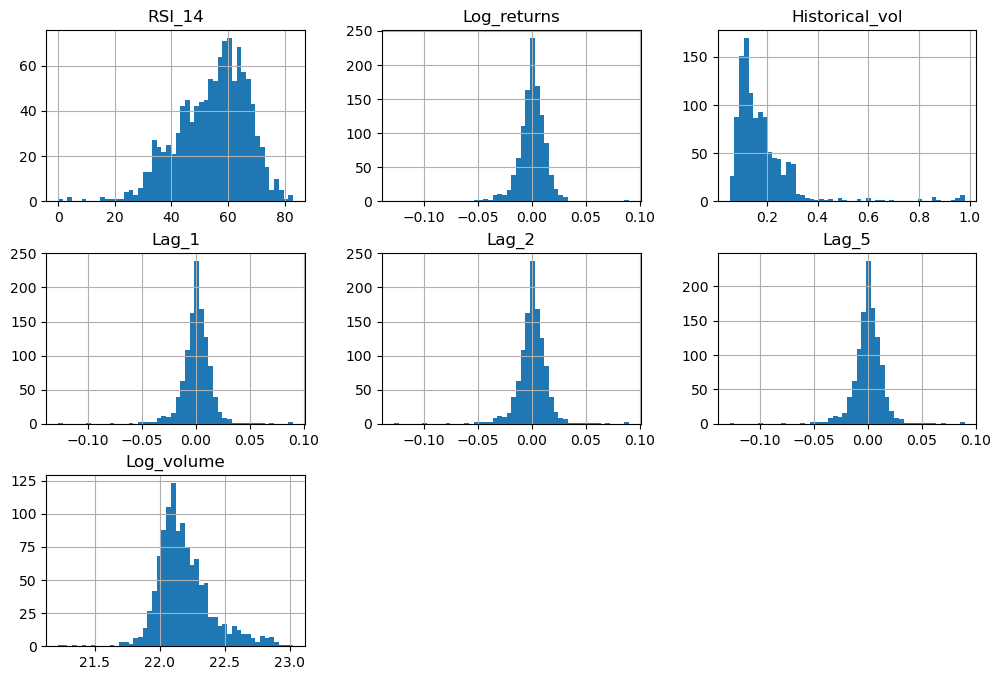

In [9]:
import seaborn as sns 
df = train_set.copy()

df.hist(bins=50, figsize=(12,8))
plt.show()

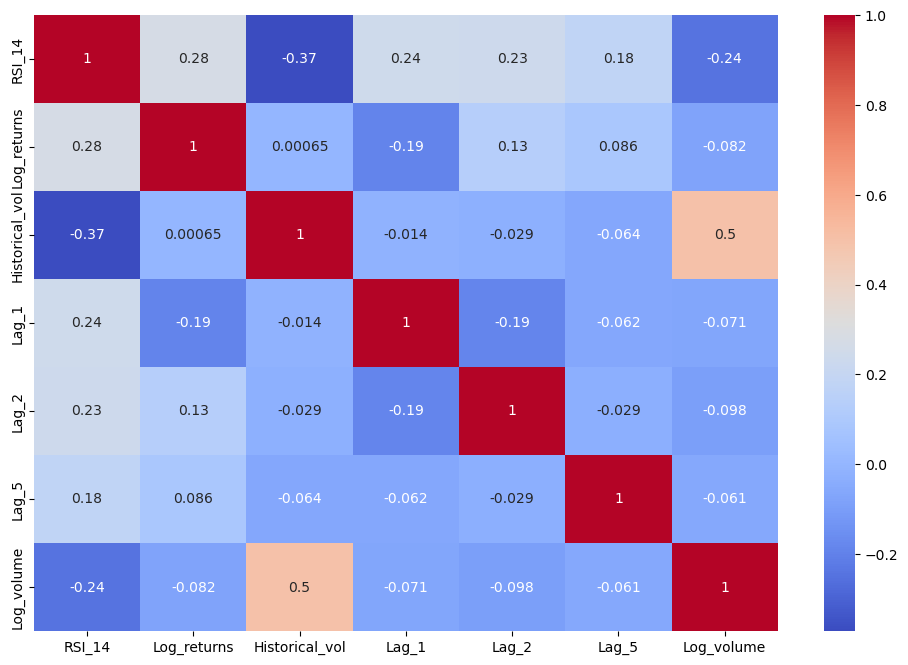

In [10]:
corr_matrix = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

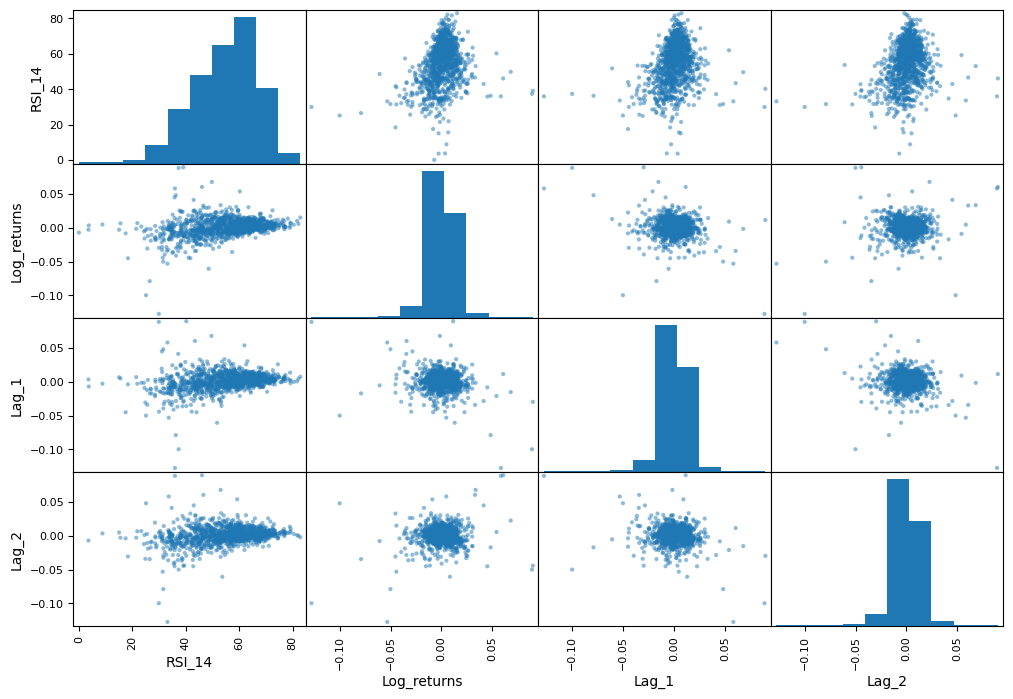

In [11]:
from pandas.plotting import scatter_matrix
attributes = ["RSI_14", "Log_returns", "Lag_1", "Lag_2"]
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

### Pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

# Columns
log_attribute = ["Historical_vol"]
yj_attribute = ["RSI_14"]

X_train, X_test = train_set.drop("Log_returns", axis=1), test_set.drop("Log_returns", axis=1)
y_train, y_test = train_set["Log_returns"], test_set["Log_returns"]

other_attributes = X_train.drop(log_attribute + yj_attribute, axis=1).columns

# Log pipeline
log_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, inverse_func=np.expm1, 
                                validate=True, feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

# Yeo-Johnson pipeline
yj_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("yj", PowerTransformer(method="yeo-johnson")),
    ("scale", StandardScaler())
])

# Others variables
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ("log", log_pipeline, log_attribute),
    ("yj", yj_pipeline, yj_attribute),
    ("num", num_pipeline, other_attributes)
])

# X/y split
X_train, X_test = train_set.drop("Log_returns", axis=1), test_set.drop("Log_returns", axis=1)
y_train, y_test = train_set["Log_returns"], test_set["Log_returns"]

# Apply preprocessor 
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [13]:
preprocessor

ColumnTransformer(transformers=[('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>,
                                                                      validate=True)),
                                                 ('scale', StandardScaler())]),
                                 ['Historical_vol']),
                                ('yj',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('yj', PowerTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['RSI_14']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 Index(['Lag_1', 'Lag_2', 'Lag_5', 'Log_volume'], dtype='object'))])

### Model

In [14]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

tscv = TimeSeriesSplit(n_splits=5)
def evaluate_model(name, model, X_train, X_test, y_train, y_test, tscv):
    # GridSearchCV (Ridge & Lasso)
    if isinstance(model.named_steps.get("ridge"), Ridge):
        alphas = np.logspace(-6, 6, 400)
        param_grid = {"ridge__alpha": alphas}
        search = GridSearchCV(model, param_grid, cv=tscv,
                              scoring="neg_root_mean_squared_error", 
                              n_jobs=-1)
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        cv_rmse = -search.best_score_
        cv_std = search.cv_results_["std_test_score"][search.best_index_]

    
    elif isinstance(model.named_steps.get("lasso"), Lasso):
        alphas = np.logspace(-4, 1, 400)
        param_grid = {"lasso__alpha": alphas}
        search = GridSearchCV(model, param_grid, cv=tscv,
                              scoring="neg_root_mean_squared_error", 
                              n_jobs=-1)
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        cv_rmse = -search.best_score_
        cv_std = search.cv_results_["std_test_score"][search.best_index_]

    # OLS
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        score = cross_val_score(model, X_train, y_train, cv=tscv,
                                scoring="neg_root_mean_squared_error")
        cv_rmse = -score.mean()
        cv_std = score.std()

    
    # Train/Test RMSE & R²
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results = {
        "Model": name, 
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "CV RMSE": cv_rmse,
        "CV STD": cv_std, 
        "Train R2": train_r2, 
        "Test R2": test_r2
    }
    return results, y_test_pred, best_model

In [15]:
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    
    # Distributions
    plt.figure(figsize=(12,8))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"Residuals distribution ({model_name})")
    plt.xlabel("Prediction error (y-ŷ)")
    plt.ylabel("Frequency")
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

    # Comparison 
    plt.figure(figsize=(12,8))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.title(f"Residuals Vs Predictions ({model_name})")
    plt.xlabel("")
    plt.ylabel("")
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)
    plt.show()

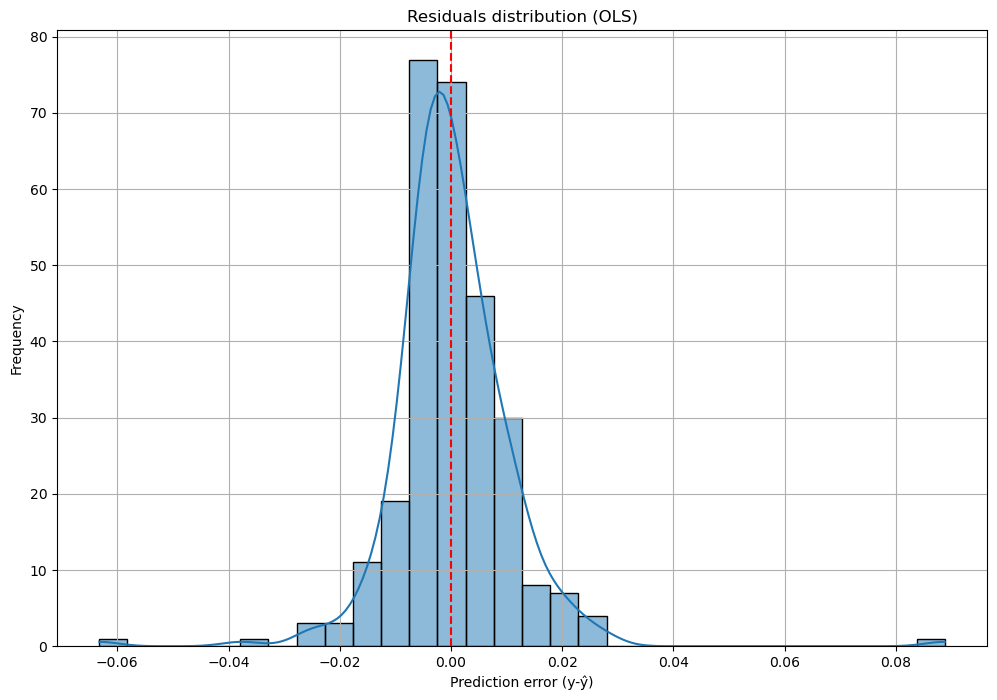

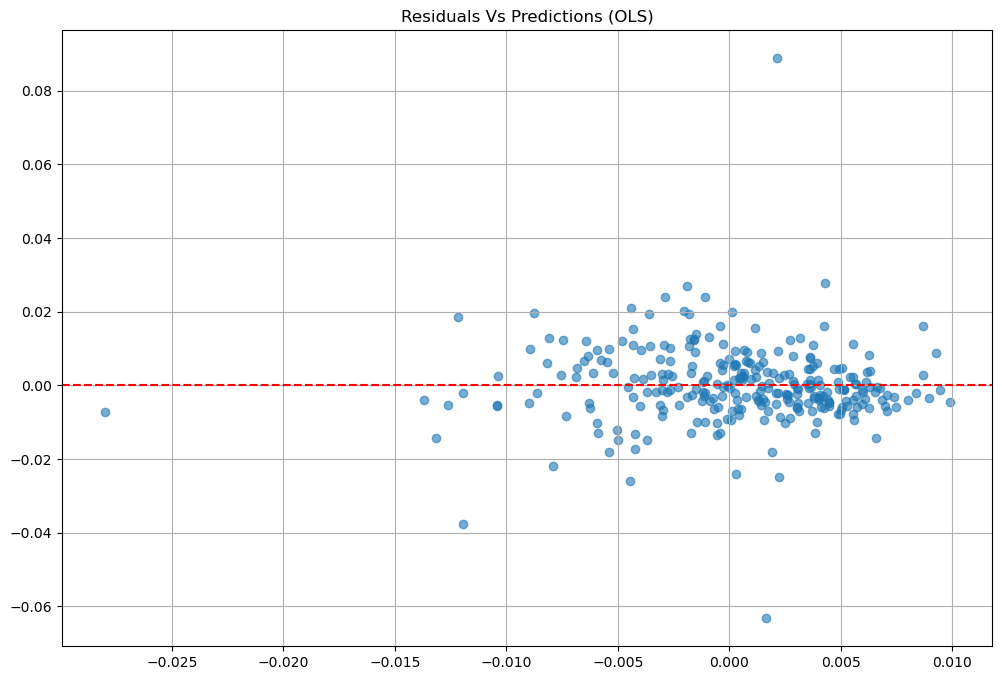

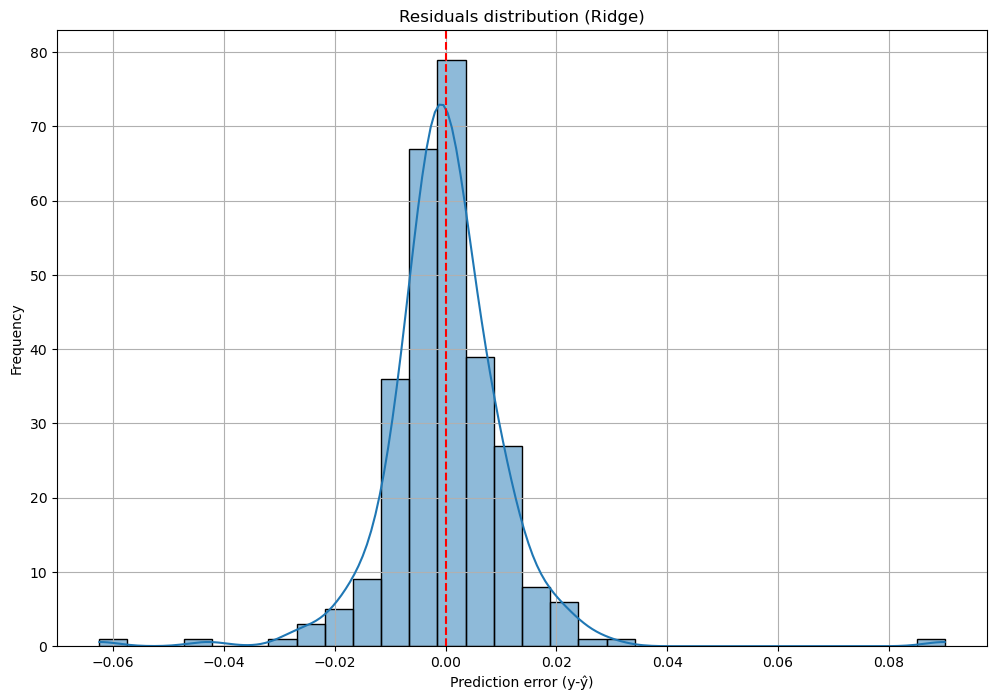

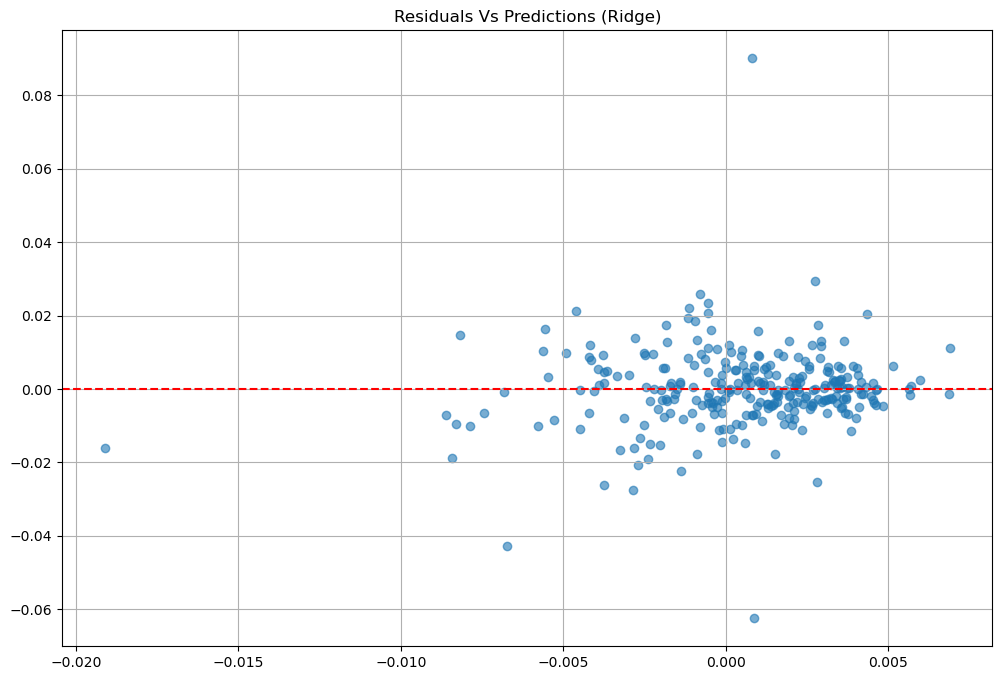

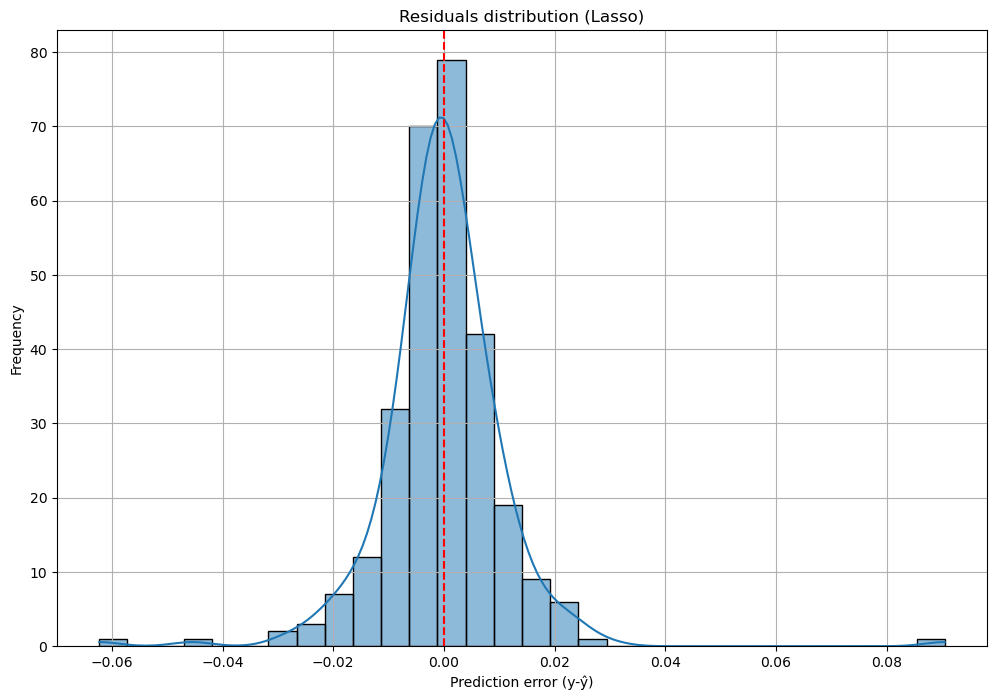

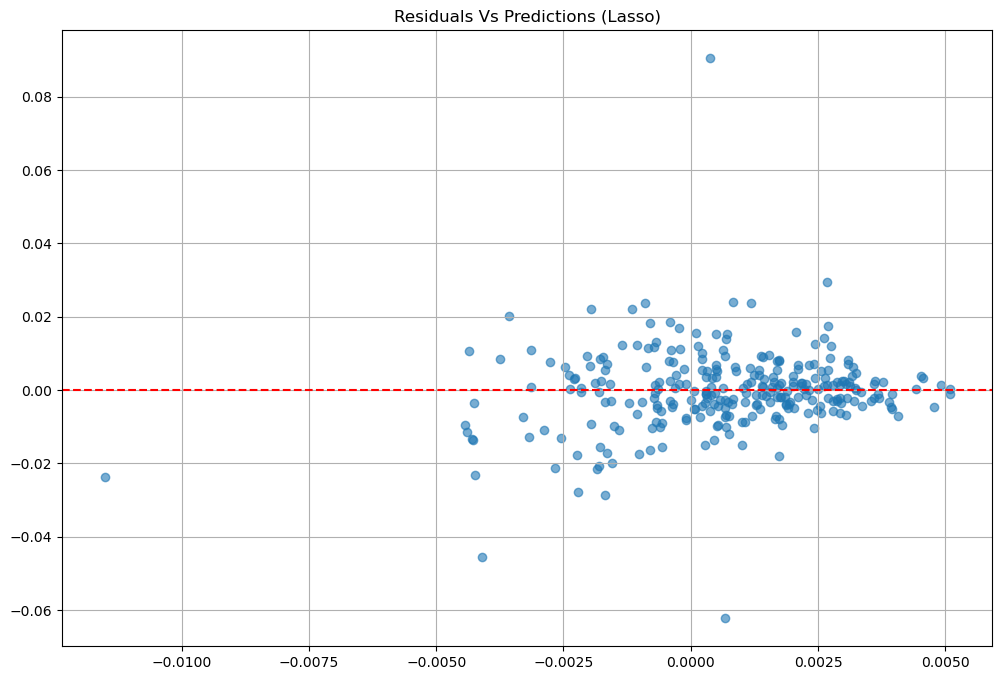

   Model  Train RMSE  Test RMSE   CV RMSE    CV STD  Train R2   Test R2
0    OLS    0.012702   0.010888  0.010351  0.002820  0.161605  0.155997
1  Ridge    0.012893   0.011098  0.009760  0.003068  0.136090  0.123126
2  Lasso    0.013182   0.011305  0.009654  0.003014  0.096915  0.090097
               Feature       OLS     Ridge     Lasso
0  log__Historical_vol  0.002600  0.001031  0.000000
1           yj__RSI_14  0.005258  0.003043  0.002285
2           num__Lag_1 -0.003928 -0.002318 -0.001428
3           num__Lag_2 -0.000106  0.000513  0.000000
4           num__Lag_5  0.000134  0.000408  0.000000
5      num__Log_volume -0.001422 -0.000702 -0.000000


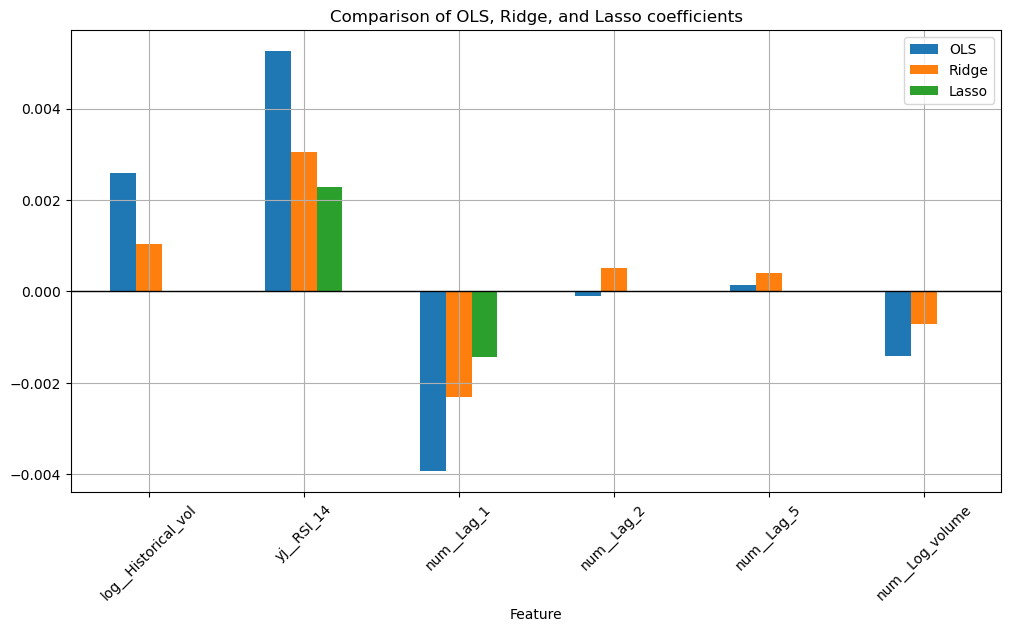

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline

models = {
    "OLS" : make_pipeline(preprocessor, LinearRegression()),
    "Ridge" : make_pipeline(preprocessor, Ridge()),
    "Lasso" : make_pipeline(preprocessor, Lasso())
}

# Results
results = []
trained_models = {}
for name, model in models.items():
    res, y_test_pred, best_model = evaluate_model(name, model, X_train, X_test, y_train, y_test, tscv)
    results.append(res)
    trained_models[name] = best_model 
    plot_residuals(y_test, y_test_pred, name)

print(pd.DataFrame(results))


# Coef table
coef_df = pd.DataFrame({"Feature": preprocessor.get_feature_names_out()})
for name, model in trained_models.items():
    final_step = [step for step in model.named_steps.values() if hasattr(step, "coef_")][0]
    coef_df[name] = final_step.coef_

print(coef_df)


# Coef plot
coef_df.set_index("Feature").plot(kind="bar", figsize=(12,6))
plt.title("Comparison of OLS, Ridge, and Lasso coefficients")
plt.axhline(0, color="black", linewidth=1)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()